# The Cancer Genome Atlas (TCGA) Breast Invasive Carcinoma (BRCA) Dataset

This dataset measures the genetic and biological effect of BRCA in a cohort of 1000+ patients. 

For this project we have subset this dataset with common and unique patients across three datasets : 
 - Transcriptomcs (mRNA)
 - Epigentics (DNAm)
 - Proteomics (RPPA)

The prediction taks in this project is tumour subtype classification. It has been shown that, depending on the specific tumour subtype, outcomes for women with BRCA will vary significantly. Therefore, being able to accruately stratify by subtype is an important characterisation for this cancer and will affect the treatment course decided by the physician. 

The different subtypes present in this dataset are : 
- Luminal A (LumA)
- Luminal B (LumB)
- Basal
- HER2

Each of these modalities will capture a different aspect of the disease, thus many methods which can integrate them have become popular. 

In this short notebook, we will look at the different data types and give some information on their biological aspects. 

In [89]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from palettable import wesanderson as wes

data_dir = "./../data/TCGA-BRCA/"
mod = ["mRNA", "DNAm" , "RPPA"]

In [90]:
data = {}
for omic in mod : 
   with open(f"{data_dir}{omic}.pkl", "rb") as f:  # 'rb' = read binary
    data[omic] = pickle.load(f) 

C:\Users\Petar\AppData\Local\Temp\ipykernel_15412\1978040916.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data[omic] = pickle.load(f)
C:\Users\Petar\AppData\Local\Temp\ipykernel_15412\1978040916.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access

## Transcriptomics (mRNA)

Transcriptomics looks at all RNA in a cell to see which genes are “on” and how strongly.

This gene expression dataset is a table of gene activity levels across breast cancer (BRCA) tissue samples

Numbers come from RNA sequencing; higher values mean more of that gene’s RNA was detected.

mRNA and genes should have a very similar distribution in a population, but when a person has a disease, the disease can cause a large change in a genes expression causing it to become over/under expressed. 

In [91]:
data['mRNA']["expr"].head()

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288611.1,ENSG00000288612.1,ENSG00000288638.1,ENSG00000288648.1,ENSG00000288657.1,ENSG00000288658.1,ENSG00000288663.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-E9-A228,11.220890,4.194486,10.680243,10.487409,9.448297,9.408937,10.505433,11.871306,10.985411,11.401380,...,3.308428,5.408347,2.843467,2.843467,2.843467,6.249685,5.485041,8.864766,4.498478,4.194486
TCGA-HN-A2NL,12.279388,3.347630,11.422199,10.338415,9.834559,8.123745,10.559379,10.412459,10.856693,11.637981,...,4.373216,4.732522,3.552924,2.843467,2.843467,6.432414,5.938534,8.195267,4.879134,6.307971
TCGA-OL-A5D7,11.436488,4.204181,11.338812,10.696614,11.024408,9.917112,9.852083,10.494274,10.290863,12.049691,...,3.469872,6.238882,2.843467,2.843467,2.843467,5.977719,5.808513,9.188112,4.707533,6.365531
TCGA-A2-A3KC,11.511191,5.737801,10.834398,10.931552,9.698790,9.609320,11.893211,11.046319,10.422642,11.226144,...,3.354080,5.578962,2.843467,3.561911,2.843467,4.064020,5.762593,8.621993,4.459940,5.431014
TCGA-A2-A0YI,12.431769,5.762581,10.823070,10.601755,8.992869,9.630460,11.674870,11.553497,11.183243,11.169297,...,3.506481,5.608277,2.843467,3.314332,2.843467,3.773210,5.460744,8.646323,4.210609,4.343591


In [92]:
data['mRNA']["meta"]

,patient,race,gender,sample_type,paper_BRCA_Subtype_PAM50,sizeFactor,replaceable
TCGA-E9-A228,TCGA-E9-A228,white,female,Primary Tumor,LumB,1.329814,True
TCGA-HN-A2NL,TCGA-HN-A2NL,not reported,female,Primary Tumor,Basal,1.129338,True
TCGA-OL-A5D7,TCGA-OL-A5D7,black or african american,female,Primary Tumor,Basal,0.727540,True
TCGA-A2-A3KC,TCGA-A2-A3KC,black or african american,female,Primary Tumor,LumA,1.100696,True
TCGA-A2-A0YI,TCGA-A2-A0YI,white,female,Primary Tumor,LumA,1.296389,True
...,...,...,...,...,...,...,...
TCGA-A2-A0T2,TCGA-A2-A0T2,white,female,Primary Tumor,Basal,0.786613,True
TCGA-E9-A249,TCGA-E9-A249,white,female,Primary Tumor,LumB,1.435994,True
TCGA-C8-A274,TCGA-C8-A274,asian,female,Primary Tumor,LumB,1.311352,True
TCGA-BH-A0C0,TCGA-BH-A0C0,white,female,Primary Tumor,LumB,0.802390,True


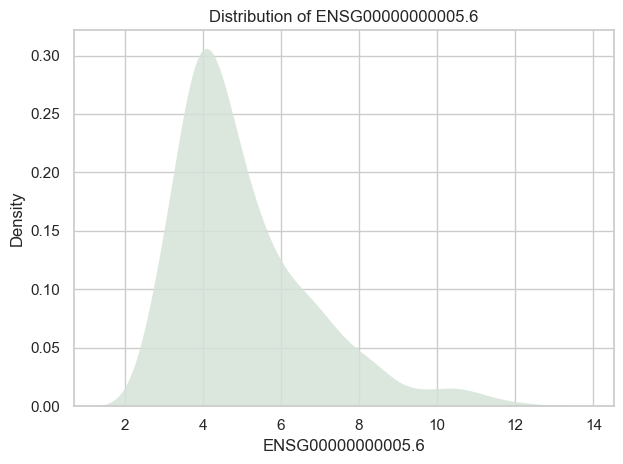

In [93]:
color = wes.Darjeeling2_5.mpl_colors[0]  # pick a color from the palette

gene = data['mRNA']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['mRNA']["expr"], x=f"{gene}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{gene}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {gene}")
plt.tight_layout()
plt.show()

## Epigentics (DNAm)

Epigenetics studies chemical tags on DNA sites that control gene activity without changing the DNA sequence.

DNA methylation is one such tag (adding methyl groups), referred to as CpGs,  that often reduces gene activity.

A DNA methylation dataset measures how much methylation is present at many genomic sites across samples.

These tags are crucial in aging for example, to stop us growing taller and taller indefinitely.

DNAm is a very useful measure for how we interact with out environment as the number and location of specific chemical tags can tell us if and how much someone consumes alcohol, smokes, works with pesticides, exposure to carcinogenics etc...  

In [94]:
data['DNAm']["expr"].head()

,cg11738485,cg01893212,cg21885317,cg12466610,cg15690342,cg22473620,cg02467990,cg23179456,cg04131969,cg22831607,...,cg00592510,cg06459913,cg01749500,cg17985854,cg16023912,cg03407594,cg07290865,cg06153893,cg10262891,cg07132590
TCGA-E9-A228,0.960700,0.644724,0.964877,0.589824,0.663511,0.649849,0.647587,0.693198,0.352195,0.726499,...,0.144670,0.758155,0.756128,0.684074,0.753583,0.695458,0.886056,0.728452,0.822799,0.788491
TCGA-HN-A2NL,0.583237,0.023547,0.966170,0.058889,0.073499,0.056420,0.020411,0.843894,0.026822,0.024529,...,0.095880,0.940490,0.817412,0.744143,0.891167,0.734321,0.852952,0.281028,0.422452,0.964047
TCGA-OL-A5D7,0.021655,0.035954,0.979647,0.828104,0.124674,0.072108,0.031360,0.025608,0.927734,0.731654,...,0.080530,0.945476,0.681666,0.447804,0.832570,0.843092,0.911593,0.045209,0.614898,0.951736
TCGA-A2-A3KC,0.031399,0.472174,0.613586,0.579223,0.709417,0.655372,0.410265,0.658779,0.925193,0.583415,...,0.291444,0.904078,0.618604,0.366992,0.781996,0.700943,0.868345,0.098596,0.664794,0.953521
TCGA-A2-A0YI,0.491925,0.544880,0.640366,0.592854,0.845361,0.639998,0.445780,0.555931,0.506736,0.675618,...,0.084366,0.930467,0.641724,0.589872,0.695018,0.746382,0.907000,0.028049,0.753637,0.964383


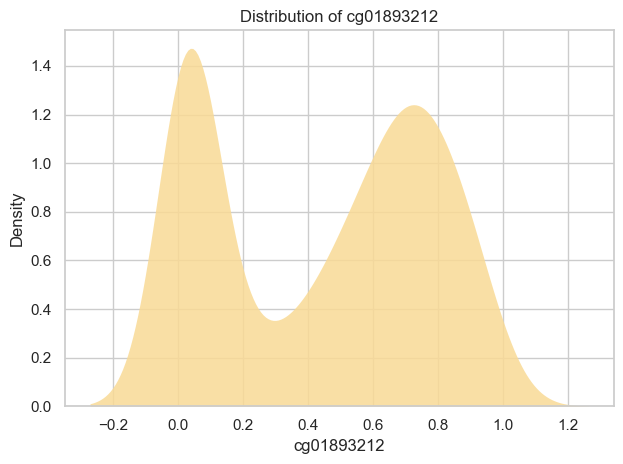

In [95]:
color = wes.Darjeeling2_5.mpl_colors[2]  # pick a color from the palette

cpg = data['DNAm']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['DNAm']["expr"], x=f"{cpg}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{cpg}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {cpg}")
plt.tight_layout()
plt.show()

## Proteomics (RPPA)

Proteomics studies all the proteins in a cell or tissue—what’s there and how much.

The proteomics dataset we are using is Reverse Phase Protein Array (RPPA). This dataset is a table of protein abundance levels across the tumour tissue samples.

It is measure by microscope technologies by tagging proteins in the samples with a chemical dye and quantifying how much of each protein is present by their illuminaiton. 

Proteomics is really useful to get an accurate pin-point snapshop of the biology of the tumour in its measured state. The downside is that protein measurements are sparse across patient samples with many missing samples as not every protein will be abundant in each patient. How you handle this artefact will be an important consideration in your analyses and could effect different models differently. 

In [96]:
data['RPPA']["expr"].head()

,1433BETA,1433EPSILON,1433ZETA,4EBP1,4EBP1_pS65,4EBP1_pT37T46,4EBP1_pT70,53BP1,ACC_pS79,ACC1,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP-70,ZEB1
TCGA-E9-A228,-0.011293,-0.060878,-0.202675,1.35820,0.020965,0.312617,0.102329,0.204165,0.604385,0.32035,...,0.231692,0.020158,-0.342985,-0.776035,0.057015,-0.340385,-0.099780,0.110625,-0.697522,0.226013
TCGA-HN-A2NL,0.252110,0.080503,0.197350,-0.29719,-0.374150,0.463070,-0.407030,-0.941850,0.765260,0.47086,...,0.579617,-0.424650,0.331740,0.371280,-0.220320,0.131920,-0.752445,-1.048190,0.480243,0.760178
TCGA-OL-A5D7,-0.014454,0.026866,-0.334580,0.67399,-0.605530,-0.491210,-0.009052,-0.384940,-0.186570,-0.56132,...,0.100363,0.100020,-0.020238,-0.605830,-0.676840,-0.154990,0.508370,-0.157935,2.031538,0.245044
TCGA-A2-A3KC,0.106510,0.241750,0.303230,-0.28122,-0.586760,-0.853800,-0.406400,-0.079820,0.155410,0.14472,...,-0.038458,0.101470,-0.074459,0.048927,-0.382870,-0.273140,-0.599380,-0.461275,0.632358,0.339843
TCGA-A2-A0YI,0.008400,0.101940,0.379810,-0.45383,-0.438570,-0.091300,-0.181230,0.489960,0.822000,0.58515,...,1.028037,0.167430,-0.351550,-0.286540,-0.432520,-0.194490,-0.290635,-0.340180,0.842933,0.077968


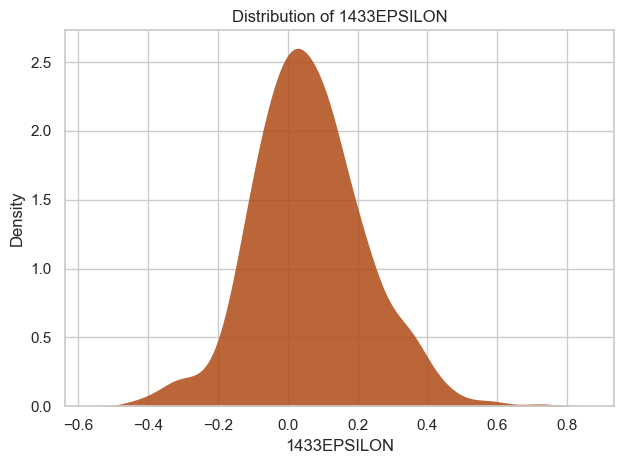

In [97]:
color = wes.Darjeeling2_5.mpl_colors[3]  # pick a color from the palette

prtn = data['RPPA']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['RPPA']["expr"], x=f"{prtn}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{prtn}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {prtn}")
plt.tight_layout()
plt.show()

## Next Steps 

1. Data Exploration Analysis (DEA)
   - How many patients are common to each omic, pairs of omics, and across all omics?
   - Missingness in each omic?
     - Methods of imputation?
   - Patient outliers?
     
2. MOFA

3. IntegrAO

4. PNet

# LOGREG

In [98]:
dnam_patients = data['DNAm']['meta']['patient']
mrna_patients = data['mRNA']['meta']['patient']
rppa_patients = data['RPPA']['meta']['patient']

set_dnam = set(dnam_patients)
set_mrna = set(mrna_patients)
set_rppa = set(rppa_patients)

intersection_dnam_mrna = set_dnam & set_mrna
intersection_mrna_rppa = set_mrna & set_rppa
intersection_dnam_rppa = set_dnam & set_rppa
intersection_all = set_dnam & set_mrna & set_rppa

print(f"Common patients between DNAm and mRNA: {len(intersection_dnam_mrna)}")
print(f"Common patients between mRNA and RPPA: {len(intersection_mrna_rppa)}")
print(f"Common patients between DNAm and RPPA: {len(intersection_dnam_rppa)}")
print(f"Common patients between all three: {len(intersection_all)}")

Common patients between DNAm and mRNA: 415
Common patients between mRNA and RPPA: 414
Common patients between DNAm and RPPA: 414
Common patients between all three: 401


In [99]:
idx_mrna = set(data["mRNA"]["expr"].index)
idx_meth = set(data["DNAm"]["expr"].index)
idx_prot = set(data["RPPA"]["expr"].index)
patients_intersection = sorted(list(idx_mrna & idx_meth & idx_prot))
print(f"Expr intersection size: {len(patients_intersection)}")

Expr intersection size: 401


In [100]:
def get_pam50(view_name):
    meta = data[view_name].get("meta", None)
    if meta is None or "paper_BRCA_Subtype_PAM50" not in meta.columns:
        return pd.Series(index=[], dtype="object")
    s = meta["paper_BRCA_Subtype_PAM50"].astype(str).str.strip()
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    s.name = view_name
    return s

In [101]:
pam_mrna = get_pam50("mRNA")
pam_meth = get_pam50("DNAm")
pam_prot = get_pam50("RPPA")
pam_df = pd.concat([pam_mrna, pam_meth, pam_prot], axis=1)
pam_df = pam_df.reindex(patients_intersection)

In [102]:
pam50 = pam_df.bfill(axis=1).iloc[:, 0]
conflict_mask = (pam_df.nunique(axis=1, dropna=True) > 1)
n_conflicts = int(conflict_mask.sum())
if n_conflicts:
    print(f"Warning: {n_conflicts} patients have conflicting PAM50 labels across metas (keeping mRNA>DNAm>RPPA).")
pam50 = pam50.dropna()
patients = pam50.index.tolist()
print(f"Patients with PAM50 on expr-intersection: {len(patients)}")

Patients with PAM50 on expr-intersection: 401


In [103]:
X_mrna = data["mRNA"]["expr"].loc[patients].values
X_meth = data["DNAm"]["expr"].loc[patients].values
X_prot = data["RPPA"]["expr"].loc[patients].values
y_str  = pam50.astype(str).values

In [104]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_str)
class_names = list(le.classes_)
print("PAM50 classes:", class_names)
print(pd.Series(y_str).value_counts())

PAM50 classes: ['Basal', 'Her2', 'LumA', 'LumB']
LumA     230
LumB      82
Basal     61
Her2      28
Name: count, dtype: int64


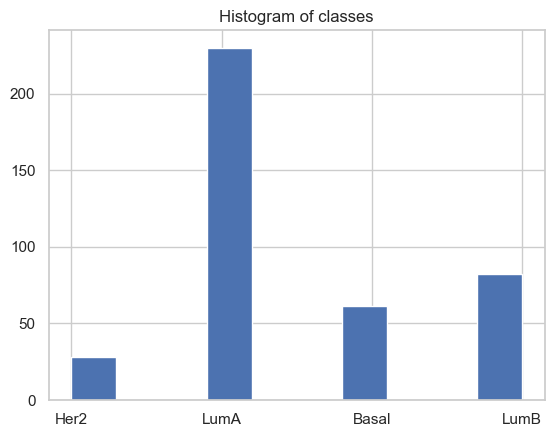

In [105]:
plt.figure()
plt.hist(y_str)
plt.title('Histogram of classes')
plt.show()

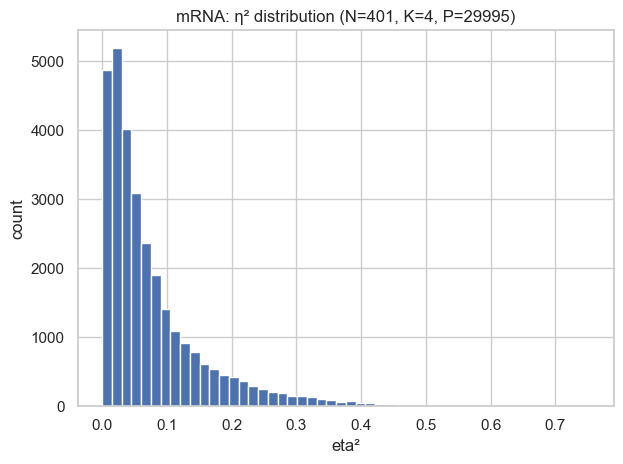

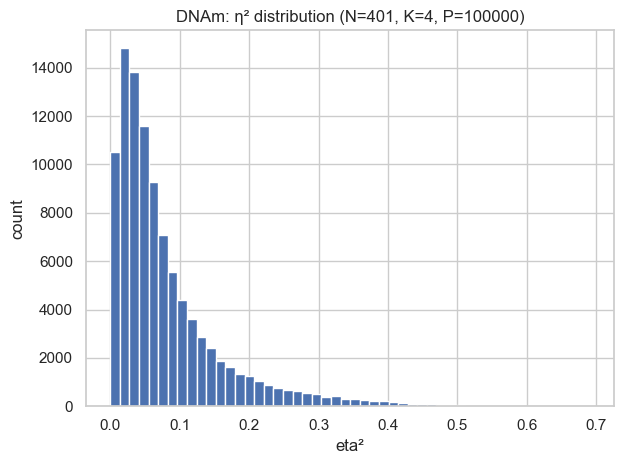

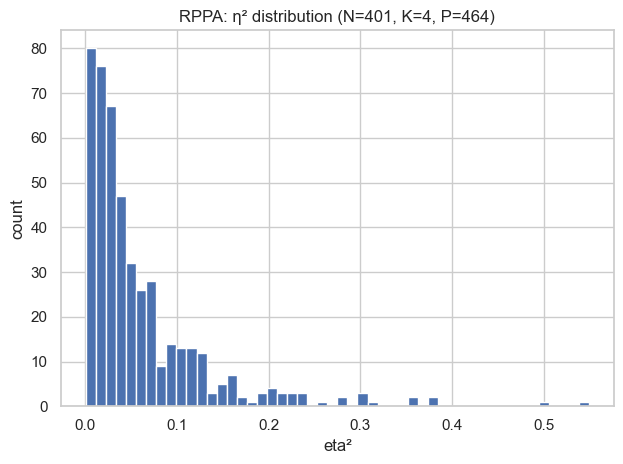

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

def per_feature_anova_np(
    X: np.ndarray,               # shape (N, P)
    y: np.ndarray,               # shape (N,), integer classes
    view_name: str,              # e.g., "mRNA", "DNAm", "RPPA"
    topN: int = 30,              # for the bar plot
    topK_scatter: int = 3000,    # for volcano-like scatter
    save_prefix: str | None = None,
    feature_names: list[str] | None = None
):
    N, P = X.shape
    K = len(np.unique(y))
    if feature_names is None:
        width = len(str(P))
        feature_names = [f"{view_name.lower()}_{i:0{width}d}" for i in range(P)]

    # 1) ANOVA F and p across classes for every feature
    F, p = f_classif(X, y)  # vector length P
    F = np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)
    p = np.nan_to_num(p, nan=1.0, posinf=1.0, neginf=1.0)

    # 2) Effect size η² (0..1)
    eta2 = ((K - 1) * F) / (((K - 1) * F) + (N - K) + 1e-12)

    # 3) Build table and save
    res = pd.DataFrame({
        "feature": feature_names,
        "F": F,
        "p": p,
        "eta2": eta2
    }).sort_values("eta2", ascending=False).reset_index(drop=True)
    res["rank"] = np.arange(1, P + 1)
    res["view"] = view_name

    
    # 4) Plots (compact summaries)
    # Histogram of eta^2
    plt.figure()
    plt.hist(res["eta2"].values, bins=50)
    plt.title(f"{view_name}: η² distribution (N={N}, K={K}, P={P})")
    plt.xlabel("eta²")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    return res

# ==== Use on your NumPy arrays (aligned to the same patients as y) ====
mrna_scores = per_feature_anova_np(X_mrna, y, "mRNA",  topN=30, topK_scatter=3000, save_prefix="mRNA")
meth_scores = per_feature_anova_np(X_meth, y, "DNAm", topN=30, topK_scatter=3000, save_prefix="DNAm")
prot_scores = per_feature_anova_np(X_prot, y, "RPPA", topN=30, topK_scatter=3000, save_prefix="RPPA")


In [125]:
s = mrna_scores["eta2"].values
# Count how many exceed practical effect thresholds
for t in [0.05, 0.1, 0.2, 0.3]:
    print(f"eta² > {t}: {(s>t).sum()} features")

eta² > 0.05: 14800 features
eta² > 0.1: 7609 features
eta² > 0.2: 2623 features
eta² > 0.3: 878 features


In [126]:
s = meth_scores["eta2"].values
# Count how many exceed practical effect thresholds
for t in [0.05, 0.1, 0.2, 0.3]:
    print(f"eta² > {t}: {(s>t).sum()} features")

eta² > 0.05: 53450 features
eta² > 0.1: 26287 features
eta² > 0.2: 8699 features
eta² > 0.3: 3154 features


In [127]:
s = prot_scores["eta2"].values
# Count how many exceed practical effect thresholds
for t in [0.05, 0.1, 0.2, 0.3]:
    print(f"eta² > {t}: {(s>t).sum()} features")

eta² > 0.05: 175 features
eta² > 0.1: 85 features
eta² > 0.2: 25 features
eta² > 0.3: 10 features


In [118]:
from sklearn.model_selection import train_test_split

X_concat = np.hstack([X_mrna, X_meth, X_prot])
idx_all = np.arange(len(y))
idx_tr, idx_te = train_test_split(idx_all, test_size=0.2, stratify=y, random_state=42)

Xtr_c, Xte_c = X_concat[idx_tr], X_concat[idx_te]
Xtr_m, Xte_m = X_mrna[idx_tr],  X_mrna[idx_te]
Xtr_d, Xte_d = X_meth[idx_tr],  X_meth[idx_te]
Xtr_p, Xte_p = X_prot[idx_tr],  X_prot[idx_te]
y_tr, y_te = y[idx_tr], y[idx_te]

### Early integration

In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score

P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1+P2))
idx_prot = list(range(P1+P2, P1+P2+P3))

def view_block(k=None):
    steps = [("scale", StandardScaler())]
    if k is not None:
        steps.append(("kbest", SelectKBest(f_classif, k=k)))
    return Pipeline(steps)
K1, K2, K3 = 878,3154,10   # where eta2 > 0.3

# we take relatively low k
K_MRNA, K_METH, K_PROT = min(K1, P1), min(K2, P2), min(K3, P3)

pre = ColumnTransformer(
    transformers=[
        ("mrna", view_block(K_MRNA), idx_mrna),
        ("meth", view_block(K_METH), idx_meth),
        ("prot", view_block(K_PROT), idx_prot),
    ],
    remainder="drop"
)

ef = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="saga",
        multi_class="multinomial",
        class_weight="balanced",
        max_iter=5000,
        n_jobs=-1,
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100]}

gs_ef = GridSearchCV(
    ef, param_grid,
    scoring={"bal_acc":"balanced_accuracy", "logloss":"neg_log_loss", "auc":"roc_auc_ovr_weighted"},
    refit="bal_acc", cv=cv, n_jobs=-1, verbose = 2
)
gs_ef.fit(Xtr_c, y_tr)

print("EF best params:", gs_ef.best_params_)
y_pred = gs_ef.predict(Xte_c)
proba  = gs_ef.predict_proba(Xte_c)

print("Balanced Acc:", balanced_accuracy_score(y_te, y_pred).round(3))
print("ROC-AUC (OvR, weighted):", roc_auc_score(y_te, proba, multi_class="ovr", average="weighted").round(3))
print(classification_report(y_te, y_pred, digits=3)) 
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


EF best params: {'clf__C': 0.1}
Balanced Acc: 0.828
ROC-AUC (OvR, weighted): 0.943
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.833     0.833     0.833         6
           2      0.854     0.891     0.872        46
           3      0.667     0.588     0.625        17

    accuracy                          0.840        81
   macro avg      0.839     0.828     0.833        81
weighted avg      0.835     0.840     0.836        81

Confusion matrix:
 [[12  0  0  0]
 [ 0  5  0  1]
 [ 0  1 41  4]
 [ 0  0  7 10]]


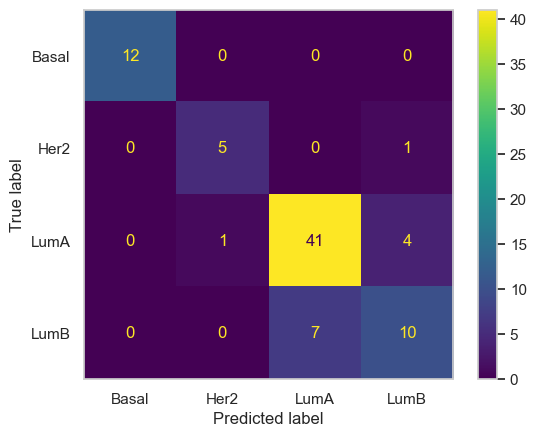

In [122]:
from sklearn.metrics import ConfusionMatrixDisplay
classes = np.unique(y_str)
cm = confusion_matrix(y_te, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.show()

### Late integration

In [123]:
def make_view_lr(k):
    return Pipeline([
        ("scale", StandardScaler()),
        ("kbest", SelectKBest(f_classif, k=k)),
        ("clf", LogisticRegression(
            penalty="l2",
            solver="saga",
            multi_class="multinomial",
            class_weight="balanced",
            max_iter=5000,
            n_jobs=-1,
            random_state=42
        ))
    ])

grid = {"clf__C":[0.01,0.1,1,10,100]}

gs_m = GridSearchCV(make_view_lr(min(K1, P1)), grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True).fit(Xtr_m, y_tr)
gs_d = GridSearchCV(make_view_lr(min(K2, P2)), grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True).fit(Xtr_d, y_tr)
gs_p = GridSearchCV(make_view_lr(min(K3, P3)), grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True).fit(Xtr_p, y_tr)

# average log-probabilities across views

logP = np.log(gs_m.predict_proba(Xte_m) + 1e-12)
logP += np.log(gs_d.predict_proba(Xte_d) + 1e-12)
logP += np.log(gs_p.predict_proba(Xte_p) + 1e-12)
logP /= 3.0

y_pred_lf = logP.argmax(axis=1)

print("LF Balanced Acc:", balanced_accuracy_score(y_te, y_pred_lf).round(3))
print(classification_report(y_te, y_pred_lf, digits=3))

C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LF Balanced Acc: 0.837
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.714     0.833     0.769         6
           2      0.889     0.870     0.879        46
           3      0.647     0.647     0.647        17

    accuracy                          0.840        81
   macro avg      0.813     0.837     0.824        81
weighted avg      0.842     0.840     0.840        81



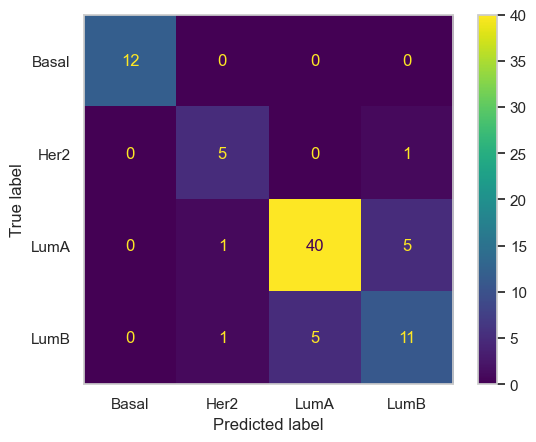

In [124]:
cm_lf = confusion_matrix(y_te, y_pred_lf)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm_lf, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.show()

Performance is not bad, we can look deeper into classes LumA and LumB, and try to get them better. Also we should CV ks, as now they were chosen in a nonsystematic way.

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# cross validating through many features based on etas
K_MRNA_grid = [878, 2623, 7609]        # P1 = 29,995
K_METH_grid = [3154, 8699, 26287]      # P2 = 100,000
K_PROT_grid = [10, 25, 85]             # P3 = 464


KBEST_TRIPLES = list(product(K_MRNA_grid, K_METH_grid, K_PROT_grid))

param_grid = [
    {
        "pre__mrna__kbest__k": [k1],
        "pre__meth__kbest__k": [k2],
        "pre__prot__kbest__k": [k3],
        "clf__C": [0.01, 0.1, 1, 10, 100],
    }
    for (k1, k2, k3) in KBEST_TRIPLES
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    ef,                    
    param_grid=param_grid,
    scoring={"bal_acc": "balanced_accuracy",
             "logloss": "neg_log_loss",
             "auc": "roc_auc_ovr_weighted"},
    refit="bal_acc",
    n_jobs=-1,
    verbose=2
)
gs.fit(Xtr_c, y_tr)

print("Best params:", gs.best_params_)
print("Best CV balanced acc:", gs.best_score_)